In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display
#matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import plot_learning_curve as plts
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tqdm import tqdm

In [2]:
train_labels=pd.read_csv('./dataset/label_binary.csv',index_col=0)
test_labels = pd.read_csv('./test/label_binary.csv',index_col=0)

In [3]:
def get_image(filename, root):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

In [4]:
def create_features(image, size=None):
    
    if type(size) == tuple:
        image = resize(image,size)

    # turn greyscale image saved as RGB into greyscale
    grey_image = rgb2gray(image)
    
    # get HOG features from greyscale image
    hog_features = hog(grey_image, 
                       block_norm='L2-Hys',
                       pixels_per_cell=(32,32)) #Value to change
    
    return hog_features

In [5]:
def create_feature_matrix(label_dataframe,root):
    features_list = []
    
    for image_id in tqdm(label_dataframe.index):
        # load image
        image = get_image(image_id,root)
        # get features for image
        image_features = create_features(image, (256,256))
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(train_labels, root='dataset/image/')
test_feature_matrix = create_feature_matrix(test_labels,root='./test/image')
print('Feature matrix shape is: ', feature_matrix.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.96it/s]

Feature matrix shape is:  (3000, 2916)


In [6]:
# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
tumor_stand = ss.fit_transform(feature_matrix)
test_stand = ss.fit_transform(test_feature_matrix)

pca = PCA(n_components=150)#can change

# use fit_transform to run PCA on our standardized matrix
tumor_pca = pca.fit_transform(tumor_stand)
test_pca = pca.fit_transform(test_stand)
# look at new shape
print('PCA matrix shape is: ', tumor_pca.shape)
print('PCA matrix shape is: ', test_pca.shape)

PCA matrix shape is:  (3000, 150)
PCA matrix shape is:  (200, 150)


In [7]:
X = pd.DataFrame(tumor_pca)
y = pd.Series(train_labels.label.values)

X_test = pd.DataFrame(test_pca)
Y_test = pd.Series(test_labels.label.values)

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=.2,
                                                  random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    2037
0     363
dtype: int64

In [8]:
#train a linear model using SVC
#svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
#svm.fit(X_train, y_train)

In [9]:
#train a sig model using SVC
#svm2 = SVC(kernel='sigmoid', probability=True, random_state=42)

#fit model
#svm2.fit(X_train, y_train)

In [10]:
#train a RBF model using SVC
svm3 = SVC(kernel = 'rbf', probability =True, random_state = 42)

#fit model
svm3.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [11]:
#train a poly model using SVC
#svm4 = SVC(kernel = 'poly', probability =True, random_state = 42)

#fit model
#svm4.fit(X_train, y_train)

In [12]:
# Validator Predictions
#y_pred = svm.predict(X_val)
#y_pred2 = svm2.predict(X_val)
y_pred3 = svm3.predict(X_val)
#y_pred4 = svm4.predict(X_val)

In [13]:
#TEST Prediction
#Y_pred_test = svm.predict(X_test)
#Y_pred_test2 = svm2.predict(X_test)
Y_pred_test3 = svm3.predict(X_test)
#Y_pred_test4 = svm4.predict(X_test)

In [14]:
# calculate Validation Accuracy
accuracy = accuracy_score(y_val, y_pred3)
#accuracy = [accuracy_score(y_val, y_pred),accuracy_score(y_val, y_pred2),accuracy_score(y_val, y_pred3),accuracy_score(y_val, y_pred4)]
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.9633333333333334


In [15]:
# calculate Test Accuracy
accuracy = accuracy_score(Y_test, Y_pred_test3)
#accuracy = [accuracy_score(Y_test, Y_pred_test),accuracy_score(Y_test, Y_pred_test2),accuracy_score(Y_test, Y_pred_test3),accuracy_score(Y_test, Y_pred_test4)]
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.865


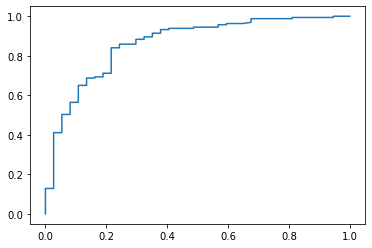

In [16]:
# predict probabilities for X_val using predict_proba
#probabilities = svm.predict_proba(X_test)
#probabilities2 = svm2.predict_proba(X_test)
probabilities3 = svm3.predict_proba(X_test)
#probabilities4 = svm4.predict_proba(X_test)

# select the probabilities for label 1.0
y_prob = probabilities3[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test,
                                                                y_prob,
                                                                pos_label = 1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

#plt.title('Receiver Operating Characteristic')
#plot the false positive rate on the x axis 
# and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,true_positive_rate,label='AUC = {:0.2f}'.format(roc_auc))

#plt.legend(loc=0)
#plt.plot([0,1], [0,1], ls='--')
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate');

<module 'matplotlib.pyplot' from 'C:\\Users\\jerem\\anaconda3\\envs\\lab\\lib\\site-packages\\matplotlib\\pyplot.py'>

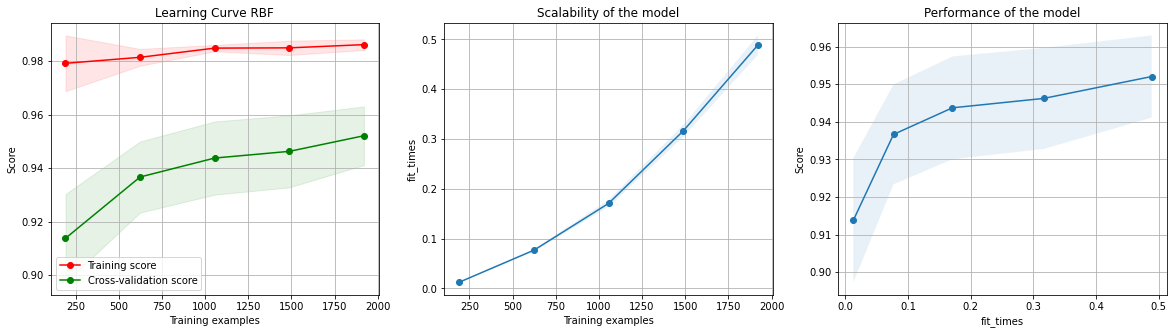

In [17]:
#plts.plot_learning_curve(estimator = svm,title = 'Learning Curve linear',X=X_train,y=y_train)
#plts.plot_learning_curve(estimator = svm2,title = 'Learning Curve logistic',X=X_train,y=y_train)
plts.plot_learning_curve(estimator = svm3,title = 'Learning Curve RBF',X=X_train,y=y_train)
#plts.plot_learning_curve(estimator = svm4,title = 'Learning Curve Polynomial',X=X_train,y=y_train)